# Netflix Recommendation System Comparison


## 1.Library import

In [2]:


import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# from wordcloud import WordCloud
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanSquaredError
import sklearn
from matplotlib import pyplot as plt
from typing import Dict, Text

tf.get_logger().setLevel('ERROR')
# tf.logging.set_verbosity(tf.logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.FATAL)



## 2. Data Preprocessing

In [4]:
movies_path = '../dataset/movies_metadata.csv'
rating_path = '../dataset/ratings_small.csv'

df_movies = pd.read_csv(movies_path).drop([19730, 29503, 35587])
df_rating = pd.read_csv(rating_path)

df_movies_cleaned = df_movies[['id', 'original_title']]
df_rating_cleaned = df_rating[['movieId', 'userId', 'rating']]
display(df_movies_cleaned.head(5))
display(df_rating_cleaned.head(5))
df_movies_cleaned['id'] = df_movies_cleaned['id'].astype('int64')

df_movies_cleaned.loc[:, 'id'] = pd.to_numeric(df_movies_cleaned['id'], errors='coerce').astype('Int64')
df_movies_cleaned = df_movies_cleaned.dropna(subset=['id']) # remove any line with NaN
display(df_movies_cleaned.head(5))

merged_dataset = pd.merge(df_rating_cleaned, df_movies_cleaned[['id', 'original_title']], left_on='movieId', right_on='id', how='left')

merged_dataset = merged_dataset[~merged_dataset['id'].isna()]
merged_dataset.dropna(inplace=True)
merged_dataset.drop('movieId', axis=1, inplace=True)
display(merged_dataset['id'].describe())
dataset_size = merged_dataset.shape[0] # count final size for dataset

merged_dataset.reset_index(drop=True, inplace=True)

display(merged_dataset.head())

df_movies_cleaned = df_movies_cleaned[~df_movies_cleaned['original_title'].duplicated()]
df_movies_cleaned['original_title'].head()

merged_dataset['userId'] = merged_dataset['userId'].astype(str)
# df_movies_cleaned['original_title'] = df_movies_cleaned['original_title'].astype(str)

rating_dict = dict(merged_dataset[['userId', 'original_title', 'rating']])
movies_dict = dict(df_movies_cleaned[['original_title']])

# Transfer to tf.tensor_slice
ratings_tf = tf.data.Dataset.from_tensor_slices(rating_dict)
movies_tf = tf.data.Dataset.from_tensor_slices(movies_dict)

movies_tf = movies_tf.map(lambda x: x["original_title"])

ratings_tf = ratings_tf.map(lambda x: {
    "original_title": x["original_title"],
    "rating": float(x["rating"]),
    "userId": x["userId"]
})

def slice_df_data(data_tf, total_size, test_rate=0.2):
    test_size = int(total_size * test_rate)
    train_size = total_size - test_size
    return data_tf.take(train_size), data_tf.skip(train_size).take(test_size)

train_ds, test_ds = slice_df_data(ratings_tf, dataset_size)
usrID_lookup = np.unique(np.concatenate([merged_dataset['userId'].to_numpy()]))
title_lookup = np.unique(np.concatenate([df_movies_cleaned['original_title']]))

/tmp/ipykernel_193093/480806534.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies = pd.read_csv(movies_path).drop([19730, 29503, 35587])


,id,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


,movieId,userId,rating
0,31,1,2.5
1,1029,1,3.0
2,1061,1,3.0
3,1129,1,2.0
4,1172,1,4.0


/tmp/ipykernel_193093/480806534.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_cleaned['id'] = df_movies_cleaned['id'].astype('int64')
/tmp/ipykernel_193093/480806534.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_cleaned.loc[:, 'id'] = pd.to_numeric(df_movies_cleaned['id'], errors='coerce').astype('Int64')
/tmp/ipykernel_193093/480806534.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting 

,id,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


count         44994.0
mean      6010.754901
std      15918.243916
min               2.0
25%             500.0
50%            1394.0
75%            2805.0
max          160718.0
Name: id, dtype: Float64

,userId,rating,id,original_title
0,1,2.5,1371,Rocky III
1,1,1.0,1405,Greed
2,1,4.0,2105,American Pie
3,1,2.0,2193,My Tutor
4,1,2.0,2294,Jay and Silent Bob Strike Back


## 3. Model construction

In [6]:
# customized model for collaborative-based system
class CollabModel(tfrs.models.Model):
  def __init__(self, rating_w, retrieval_w, embedding_dim=64, L1_num=256, L2_num=128, L3_num=32, act_func="relu") -> None:
    super().__init__()
    embedding_dim = embedding_dim # number of dimension for embedding

    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=title_lookup, mask_token=None),
      tf.keras.layers.Embedding(len(title_lookup) + 1, embedding_dim)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=usrID_lookup, mask_token=None),
      tf.keras.layers.Embedding(len(usrID_lookup) + 1, embedding_dim)
    ])
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(L1_num, activation=act_func), # first layer
        tf.keras.layers.Dense(L2_num, activation=act_func), # second layer
        tf.keras.layers.Dense(L3_num, activation=act_func),# third layer
        tf.keras.layers.Dense(1), # output layer
    ])

    self.rating_eval: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss = MeanSquaredError(),
        metrics = [RootMeanSquaredError(), MeanAbsoluteError()],
    )
    self.retrieval_eval: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies_tf.batch(128).map(self.movie_model)
        )
    )

    self.rating_weight = rating_w
    self.retrieval_weight = retrieval_w

  # overloading call function
  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    user_embeddings = self.user_model(features["userId"])
    movie_embeddings = self.movie_model(features["original_title"])
    
    return (
        user_embeddings,
        movie_embeddings,
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  # overloading compute_loss function
  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor: 
    label_r = features.pop("rating")
    user_embeddings, movie_embeddings, rating_pred = self(features)
    rating_loss = self.rating_eval(labels=label_r, predictions=rating_pred)
    retrieval_loss = self.retrieval_eval(user_embeddings, movie_embeddings)

    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

## 4. Model training

In [18]:
model = CollabModel(rating_w=1.0, retrieval_w=1.0, embedding_dim=64, L1_num=256, L2_num=128, L3_num=32, act_func="relu")
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.2))

train_ds_cache = train_ds.shuffle(10_000).batch(1_000).cache()
test_ds_cache = test_ds.batch(1_000).cache()

history = model.fit(train_ds_cache, epochs=10)

Epoch 1/10
36/36 [==============================] - 31s 833ms/step - mean_squared_error: 13.7927 - root_mean_squared_error: 3.7139 - mean_absolute_error: 3.5578 - factorized_top_k/top_1_categorical_accuracy: 3.3337e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0056 - factorized_top_k/top_10_categorical_accuracy: 0.0147 - factorized_top_k/top_50_categorical_accuracy: 0.0938 - factorized_top_k/top_100_categorical_accuracy: 0.1733 - loss: 6783.9349 - regularization_loss: 0.0000e+00 - total_loss: 6783.9349
Epoch 2/10
36/36 [==============================] - 32s 886ms/step - mean_squared_error: 13.8271 - root_mean_squared_error: 3.7185 - mean_absolute_error: 3.5615 - factorized_top_k/top_1_categorical_accuracy: 4.1671e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0126 - factorized_top_k/top_10_categorical_accuracy: 0.0329 - factorized_top_k/top_50_categorical_accuracy: 0.1874 - factorized_top_k/top_100_categorical_accuracy: 0.3151 - loss: 6325.9913 - regularization_loss: 0.000

In [59]:
model.summary()

Model: "collab_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 64)                2775808   
                                                                 
 sequential_10 (Sequential)  (None, 64)                43008     
                                                                 
 sequential_11 (Sequential)  (None, 1)                 70081     
                                                                 
 ranking_3 (Ranking)         multiple                  0         
                                                                 
 retrieval_3 (Retrieval)     multiple                  1         
                                                                 
Total params: 2,888,898
Trainable params: 2,888,897
Non-trainable params: 1
_________________________________________________________________


In [58]:
# cpy_model = CollabModel(rating_w=1.0, retrieval_w=1.0, embedding_dim=64, L1_num=256, L2_num=128, L3_num=32, act_func="relu")
# cpy_model = tf.keras.models.clone_model(model)

# # cpy_model.retrieval_eval = tfrs.tasks.Retrieval()
# # # cpy_model.rating_eval = tfrs.tasks.Ranking()
# # cpy_model.compile()
# cpy_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.2))
save_path = '../model/MRS_v2_e64_20_ep5.tf'
model.save_weights(filepath=save_path, save_format='tf')

## 5. Model Evaluation

### retrieval_w = 1.0 rating_w = 1.0

In [ ]:
metrics = model.evaluate(test_ds_cache, return_dict=True)

In [24]:
print(f"\nRetrieval top-10 accuracy: {metrics['factorized_top_k/top_10_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")
print(f"Ranking MAE: {metrics['mean_absolute_error']:.3f}")


Retrieval top-10 accuracy: 0.005
Ranking RMSE: 3.777
Ranking MAE: 3.633


### retrieval_w = 1.0 rating_w = 0

### retrieval_w = 0 rating_w = 1.0

### Plotting train process

In [ ]:
display(history.history)

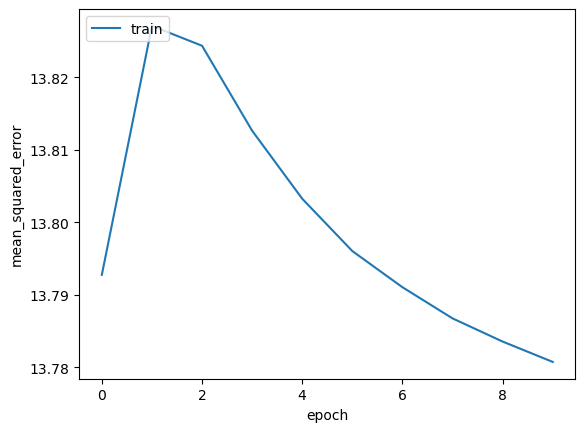

In [27]:
plt.plot(history.history['mean_squared_error'])
# plt.title('model accuracy')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


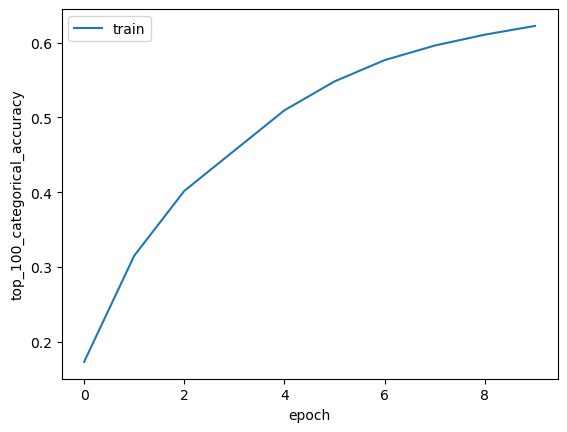

In [28]:
plt.plot(history.history['factorized_top_k/top_100_categorical_accuracy'])
plt.ylabel('top_100_categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

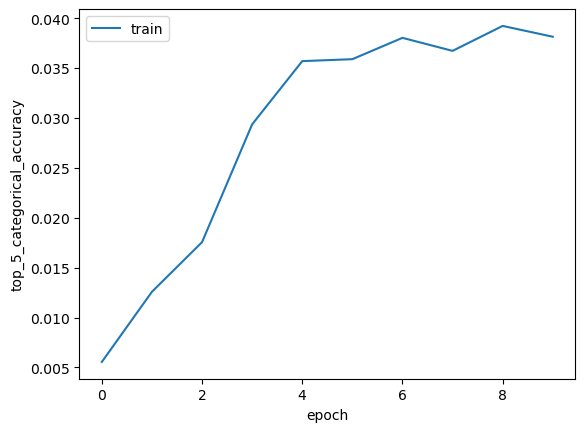

In [42]:
plt.plot(history.history['factorized_top_k/top_5_categorical_accuracy'])
plt.ylabel('top_5_categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

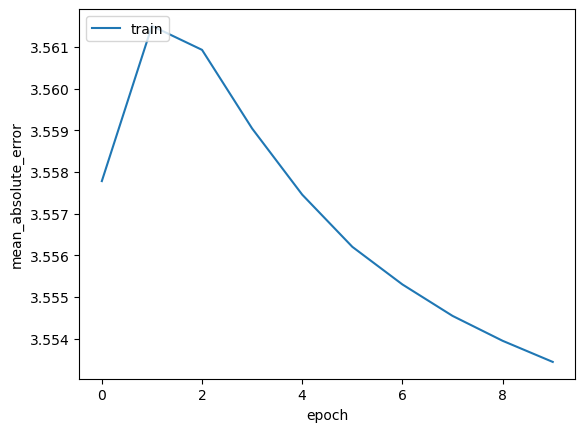

In [29]:
plt.plot(history.history['mean_absolute_error'])
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 6. Using the model

In [30]:
movies = tf.data.Dataset.from_tensor_slices(dict(df_movies_cleaned[['original_title']]))
movies = movies.map(lambda x: x["original_title"])

In [31]:
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

In [32]:
# Movie model index
index_M = tfrs.layers.factorized_top_k.BruteForce(model.movie_model)
# recommends movies out of the entire movies dataset.
index_M.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

In [41]:
# Recommendation function
# [@usrID]: num string user id
# [@showRating]: boolean to decide if showing rating.
def get_recommend(usrID, showRating):
  _, titles = index(tf.constant([usrID]))
  pred_movies = pd.DataFrame({'original_title': [i.decode('utf-8') for i in titles[0,:5].numpy()]})
  display(pred_movies)


In [34]:
get_recommend('123', False)

,original_title
0,Kurz und schmerzlos
1,The Wanderers
2,The Greatest Story Ever Told
3,La révolution française
4,Jezebel


In [39]:
# Recommendation function
# [@usrID]: num string user id
# [@showRating]: boolean to decide if showing rating.
def M_get_recommend(movie_titles, showRating):
  _, titles = index_M(tf.constant([movie_titles]))
  pred_movies = pd.DataFrame({'original_title': [i.decode('utf-8') for i in titles[0,:5].numpy()]})
  display(pred_movies)

In [40]:
M_get_recommend('Rocky III', False)

,original_title
0,Rocky III
1,Rocky V
2,Sweet Sixteen
3,The Discovery of Heaven
4,Rocky IV
